In [1]:
from src.skeleton import BaseModel

In [2]:
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
import torch

In [3]:
mnist_train_dataset = MNIST('./datasets', download=True, train=True, transform=transforms.ToTensor())
mnist_test_dataset = MNIST('./datasets', download=True, train=False, transform=transforms.ToTensor())
print(len(mnist_train_dataset), len(mnist_test_dataset))

60000 10000


In [4]:
#print(mnist_train_dataset)
#print(mnist_train_dataset.targets.shape)
#print(mnist_train_dataset.data.shape)
N_NEGATIVE = 1000
P=0.2
positive_set_train = mnist_train_dataset.data[mnist_train_dataset.targets==0]
negative_set_train = mnist_train_dataset.data[mnist_train_dataset.targets!=0][:N_NEGATIVE]
positive_set_test = mnist_test_dataset.data[mnist_test_dataset.targets==0]
negative_set_test = mnist_test_dataset.data[mnist_test_dataset.targets!=0][:positive_set_test.shape[0]]
print(positive_set_train.shape, negative_set_train.shape,positive_set_test.shape,negative_set_test.shape)

torch.Size([5923, 28, 28]) torch.Size([1000, 28, 28]) torch.Size([980, 28, 28]) torch.Size([980, 28, 28])


In [5]:
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import numpy as np
class MNIST_Anomaly(Dataset):
    def __init__(self, dataset, y, p = None):
        self.dataset = dataset
        self.y = y
        if p is None:
            self.mask = [True] * len(dataset)
        else:
            self.mask = np.random.choice(len(dataset), len(dataset), replace=False) < p*len(dataset)
    def __len__(self):
        return len(self.dataset)
    def __getitem__(self, index):
        X = self.dataset[index]
        y = self.y[index]
        M = self.mask[index]
        return X,y,M
    
dataset_p_train = MNIST_Anomaly(positive_set_train, [torch.tensor(0.0)]*len(positive_set_train), p=P)
dataset_n_train = MNIST_Anomaly(negative_set_train, mnist_train_dataset.targets[mnist_train_dataset.targets!=0], p=P)
dataset_p_test = MNIST_Anomaly(positive_set_test, [torch.tensor(0.0)]*len(positive_set_test))
dataset_n_test = MNIST_Anomaly(negative_set_test, mnist_test_dataset.targets[mnist_test_dataset.targets!=0])
dataset_train = ConcatDataset([dataset_p_train, dataset_n_train])
dataset_test = ConcatDataset([dataset_p_test, dataset_n_test])
print(len(dataset_train), len(dataset_test))
print(len(dataset_p_train), len(dataset_n_train), len(dataset_p_test), len(dataset_n_test))

6923 1960
5923 1000 980 980


In [6]:
BATCH = 256
EPOCH = 100
LR = 1e-3
LAMBDA = 1e-2
ETA = 1.0

In [7]:
train_loader = DataLoader(dataset_train, batch_size=BATCH, shuffle=True)
test_loader = DataLoader(dataset_test, batch_size=BATCH)

In [8]:
import torch.nn as nn

HDIM = 64

def init_c(model, train_loader, eps=0.1):
    n = 0
    c = torch.zeros(HDIM)
    
    model.eval()
    
    for batch, label, mask in train_loader:
        batch = model.preprocess(batch, label, mask)
        with torch.no_grad():
            pred = model(batch, label, mask)
        n += pred.shape[0]
        c += torch.sum(pred, dim=0)
    c /= n
    
    c[(abs(c) < eps) & (c<0)] = -eps
    c[(abs(c) < eps) & (c>0)] = eps
    
    return c.unsqueeze(0)


class MyModel(BaseModel):
    def __init__(self, in_dim, c=None, train_loader=None, shift=0.0, scale=1.0, model_name='my_model'):
        super().__init__(model_name=model_name)
        self.enc1 = nn.Linear(in_dim, 256)
        self.enc2 = nn.Linear(256,128)
        self.enc3 = nn.Linear(128,HDIM)
        self.relu = nn.ReLU()
        self.shift = shift
        self.scale = scale
        if c is None:
            self.c = init_c(self, train_loader)
        else:
            self.c = c
        
        self.c = self.c.to(device='cuda')
        
    def forward(self, batch, label=None, mask=None):
        x = self.enc1(batch)
        x = self.relu(x)
        x = self.enc2(x)
        x = self.relu(x)
        x = self.enc3(x)
        return x
    
    def preprocess(self, batch, label=None, mask=None):
        batch = (batch-self.shift) / self.scale
        return batch.view(batch.size(0),-1)
    
    def criterion(self, pred=None, batch=None, label=None, mask=None):
        #print(pred.shape, self.c.shape)
        #print(pred[~mask].shape, (~mask).sum(), (mask&(label==0)).sum(), (mask&(label!=0)).sum())
        loss = nn.MSELoss(reduction='none')(pred[~mask], self.c.repeat((~mask).sum(),1)).mean(-1)
        loss_positive = nn.MSELoss(reduction='none')(pred[mask&(label==0)], self.c.repeat((mask&(label==0)).sum(),1)).mean(-1)
        loss_negative = nn.MSELoss(reduction='none')(pred[mask&(label!=0)], self.c.repeat((mask&(label!=0)).sum(),1)).mean(-1)
        loss = (loss.sum() + loss_positive.sum() + (1/(loss_negative+1e-10)).sum()) / (loss.shape[0]+loss_positive.shape[0]+loss_negative.shape[0])
        return loss


In [9]:
model = MyModel(28*28, shift=positive_set_train.min(), scale=(positive_set_train.max()-positive_set_train.min()+1e-10), train_loader=train_loader)
model.cuda()

MyModel(
  (enc1): Linear(in_features=784, out_features=256, bias=True)
  (enc2): Linear(in_features=256, out_features=128, bias=True)
  (enc3): Linear(in_features=128, out_features=64, bias=True)
  (relu): ReLU()
)

In [10]:
import torch.optim as optim
optimizer = optim.Adam(model.parameters(), LR, weight_decay=LAMBDA)

In [11]:
model.train_model(train_loader, test_loader, EPOCH, optimizer, report_intv=10)

(0.41s) [Epoch 1]
	Train Loss : 8.5654e-01	Train Score : 0.0000
	Eval Loss : 3.2536e+00	Eval Score : 0.0000
(0.13s) [Epoch 11]
	Train Loss : 1.3217e-01	Train Score : 0.0000
	Eval Loss : 3.4655e+00	Eval Score : 0.0000
(0.13s) [Epoch 21]
	Train Loss : 1.1978e-01	Train Score : 0.0000
	Eval Loss : 8.1833e+00	Eval Score : 0.0000
(0.13s) [Epoch 31]
	Train Loss : 1.2420e-01	Train Score : 0.0000
	Eval Loss : 6.7463e+00	Eval Score : 0.0000
(0.13s) [Epoch 41]
	Train Loss : 1.1803e-01	Train Score : 0.0000
	Eval Loss : 4.9947e+00	Eval Score : 0.0000
(0.12s) [Epoch 51]
	Train Loss : 1.2255e-01	Train Score : 0.0000
	Eval Loss : 4.5773e+00	Eval Score : 0.0000
(0.12s) [Epoch 61]
	Train Loss : 1.2012e-01	Train Score : 0.0000
	Eval Loss : 6.0617e+00	Eval Score : 0.0000
(0.14s) [Epoch 71]
	Train Loss : 1.1952e-01	Train Score : 0.0000
	Eval Loss : 3.2745e+00	Eval Score : 0.0000
(0.13s) [Epoch 81]
	Train Loss : 1.1964e-01	Train Score : 0.0000
	Eval Loss : 1.3202e+01	Eval Score : 0.0000
(0.13s) [Epoch 91]
	

In [12]:
def run_inference(model, dataloader):
    model.eval()
    losses = []
    ys = []
    criterion = nn.MSELoss(reduction='none')
    for batch, label, mask in dataloader:
        batch = batch.cuda().to(dtype=torch.float)
        batch = model.preprocess(batch)
        with torch.no_grad():
            pred = model.forward(batch)
        loss = criterion(pred, model.c.repeat(pred.shape[0],1)).view(pred.shape[0],-1).mean(-1)
        losses.append(loss.cpu())
        label[~mask] = -1
        ys.append(label)
    losses = torch.cat(losses, 0)
    ys = torch.cat(ys, 0)
    return losses, ys

def find_thres(losses, sigma=3):
    mean = losses.mean()
    std = losses.std()
    thres = mean+std*sigma
    return thres.item()


In [13]:
train_loader_noshuffle =  DataLoader(dataset_train, batch_size=BATCH, shuffle=False)
losses_train, ys_train = run_inference(model, train_loader_noshuffle)

print(losses_train.shape)

torch.Size([6923])


tensor(1185) tensor(200) tensor(5538)


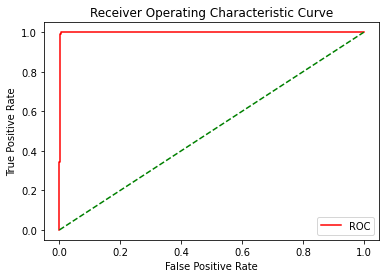

Thres : 2.2779e+00,	FPR : 0.0000,	TPR : 0.0000
Thres : 1.2779e+00,	FPR : 0.0000,	TPR : 0.0050
Thres : 5.3486e-01,	FPR : 0.0000,	TPR : 0.3450
Thres : 5.3051e-01,	FPR : 0.0008,	TPR : 0.3450
Thres : 4.5602e-01,	FPR : 0.0008,	TPR : 0.5500
Thres : 4.5572e-01,	FPR : 0.0017,	TPR : 0.5500
Thres : 4.1586e-01,	FPR : 0.0017,	TPR : 0.6650
Thres : 4.1373e-01,	FPR : 0.0025,	TPR : 0.6650
Thres : 2.8423e-01,	FPR : 0.0025,	TPR : 0.9600
Thres : 2.8237e-01,	FPR : 0.0034,	TPR : 0.9600
Thres : 2.4214e-01,	FPR : 0.0034,	TPR : 0.9900
Thres : 2.4196e-01,	FPR : 0.0042,	TPR : 0.9900
Thres : 2.3008e-01,	FPR : 0.0042,	TPR : 1.0000
Thres : 1.0577e-06,	FPR : 1.0000,	TPR : 1.0000
Best Thres : 2.3008e-01


In [14]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
print((ys_train==0).sum(), (ys_train>0).sum(), (ys_train<0).sum())
fpr, tpr, thresholds = roc_curve([0]*losses_train[ys_train==0].shape[0]+[1]*losses_train[ys_train>0].shape[0], losses_train[ys_train>=0].flatten())
def plot_roc_curve(fper, tper):
    plt.plot(fper, tper, color='red', label='ROC')
    plt.plot([0, 1], [0, 1], color='green', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend()
    plt.show()
plot_roc_curve(fpr,tpr)
thres = 0.0
best_score = 0.0
for i in range(len(fpr)):
    score = tpr[i]+1-fpr[i]
    if score > best_score:
        best_score = score
        thres = thresholds[i]
    print("Thres : %.4e,\tFPR : %.4f,\tTPR : %.4f"%(thresholds[i],fpr[i],tpr[i]))
#print(fpr,tpr,thres)
print('Best Thres : %.4e'%thres)

In [15]:
losses, ys = run_inference(model, test_loader)

losses_p = losses[ys==0]
losses_n = losses[ys!=0]
print(losses_p.shape, losses_n.shape)

torch.Size([980]) torch.Size([980])


In [16]:
TP = len(losses_p[losses_p<thres])
FN = len(losses_p[losses_p>thres])
TN = len(losses_n[losses_n>thres])
FP = len(losses_n[losses_n<thres])
print('TP : %5d,\tFP : %5d'%(TP, FP))
print('FN : %5d,\tTN : %5d'%(FN ,TN))
print('Accuracy : %.2f,\tPrecision : %.2f,\tRecall : %.2f'%((TP+TN)/(TP+TN+FP+FN), (TP)/(TP+FP+1e-10), (TP)/(TP+FN)))

TP :   979,	FP :   183
FN :     1,	TN :   797
Accuracy : 0.91,	Precision : 0.84,	Recall : 1.00


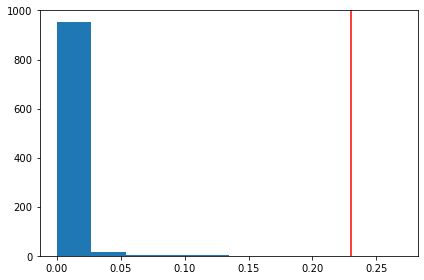

[Normal]
Max : 0.2689	Mean : 0.0031	Min : 0.0000



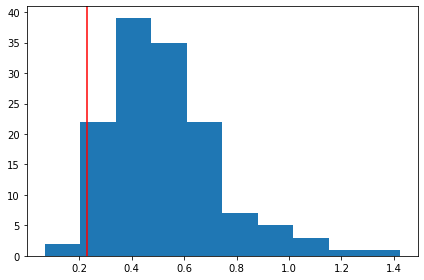

[Anomaly 1]
Max : 1.4231	Mean : 0.5238	Min : 0.0682



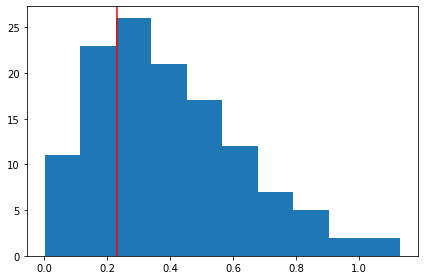

[Anomaly 2]
Max : 1.1291	Mean : 0.3939	Min : 0.0007



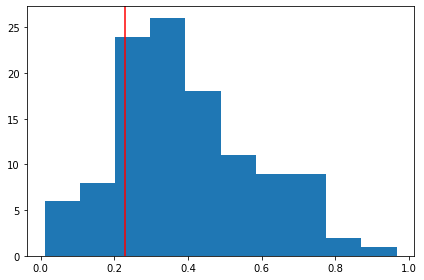

[Anomaly 3]
Max : 0.9667	Mean : 0.3969	Min : 0.0106



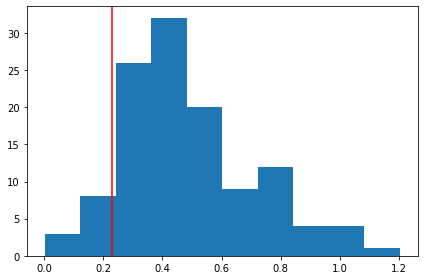

[Anomaly 4]
Max : 1.2021	Mean : 0.4828	Min : 0.0024



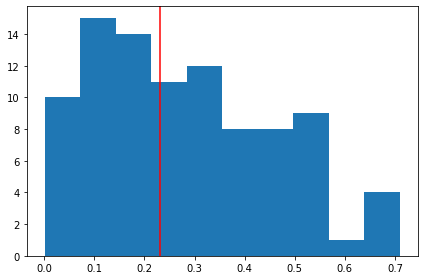

[Anomaly 5]
Max : 0.7098	Mean : 0.2817	Min : 0.0008



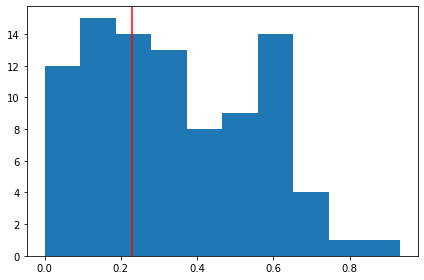

[Anomaly 6]
Max : 0.9315	Mean : 0.3373	Min : 0.0004



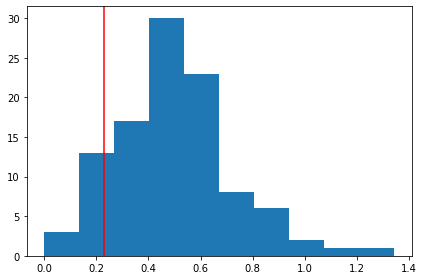

[Anomaly 7]
Max : 1.3423	Mean : 0.4956	Min : 0.0014



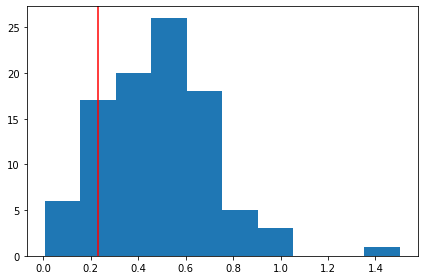

[Anomaly 8]
Max : 1.5027	Mean : 0.4800	Min : 0.0055



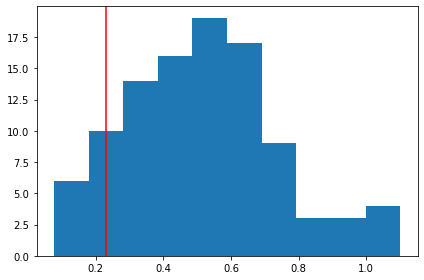

[Anomaly 9]
Max : 1.1013	Mean : 0.5130	Min : 0.0758



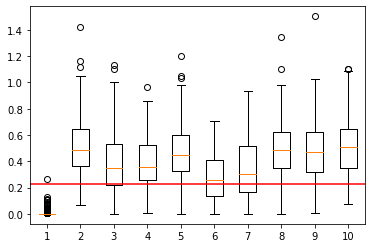

In [17]:
import matplotlib.pyplot as plt
maxes=[]
means=[]
mins=[]
lois = [losses[ys==i] for i in range(10)]
for i in range(10):
    loi = lois[i]
    counts, bins = np.histogram(loi)
    plt.hist(bins[:-1], bins, weights=counts)
    plt.axvline(thres, c='r')
    plt.tight_layout()
    plt.show()
    if i==0:
        print('[Normal]')
    else:
        print('[Anomaly %d]'%i)
    maxes.append(loi.max())
    means.append(loi.mean())
    mins.append(loi.min())
    print('Max : %.4f\tMean : %.4f\tMin : %.4f\n'%(maxes[-1], means[-1], mins[-1]))
    
plt.boxplot(lois)
plt.axhline(thres, c='r')
plt.show()

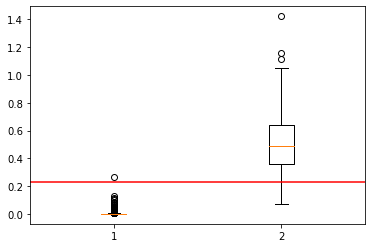

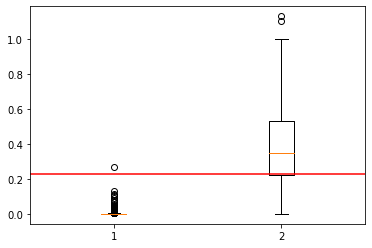

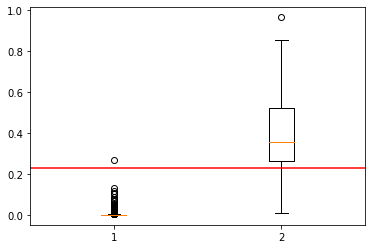

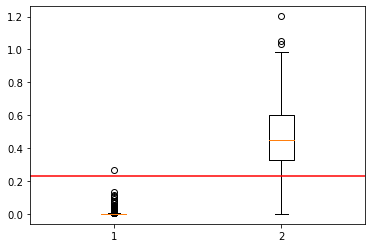

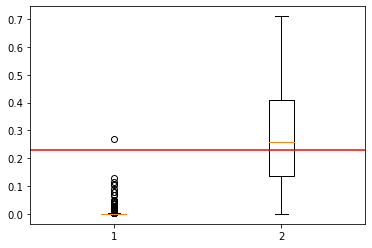

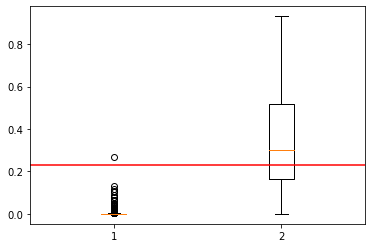

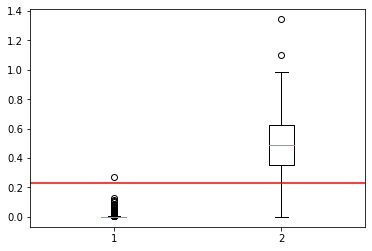

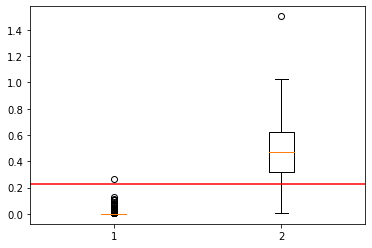

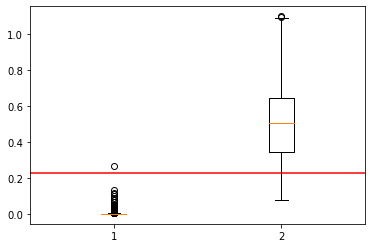

In [18]:
for i in range(9):
    plt.boxplot([lois[0],lois[i+1]])
    plt.axhline(thres, c='r')
    plt.show()

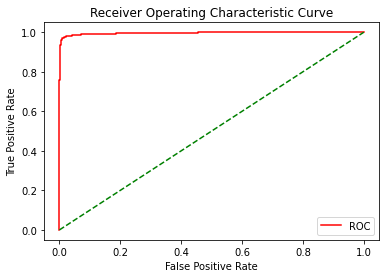

Thres : 2.5027e+00,	FPR : 0.0000,	TPR : 0.0000
Thres : 1.5027e+00,	FPR : 0.0000,	TPR : 0.0010
Thres : 2.6939e-01,	FPR : 0.0000,	TPR : 0.7602
Thres : 2.6888e-01,	FPR : 0.0010,	TPR : 0.7602
Thres : 1.3058e-01,	FPR : 0.0010,	TPR : 0.9286
Thres : 1.3053e-01,	FPR : 0.0020,	TPR : 0.9286
Thres : 1.2007e-01,	FPR : 0.0020,	TPR : 0.9337
Thres : 1.1617e-01,	FPR : 0.0031,	TPR : 0.9337
Thres : 1.0942e-01,	FPR : 0.0031,	TPR : 0.9378
Thres : 1.0874e-01,	FPR : 0.0041,	TPR : 0.9378
Thres : 1.0259e-01,	FPR : 0.0041,	TPR : 0.9408
Thres : 1.0257e-01,	FPR : 0.0051,	TPR : 0.9408
Thres : 8.9068e-02,	FPR : 0.0051,	TPR : 0.9500
Thres : 8.8130e-02,	FPR : 0.0061,	TPR : 0.9500
Thres : 8.0348e-02,	FPR : 0.0061,	TPR : 0.9612
Thres : 7.7739e-02,	FPR : 0.0082,	TPR : 0.9612
Thres : 6.8186e-02,	FPR : 0.0082,	TPR : 0.9684
Thres : 6.6404e-02,	FPR : 0.0112,	TPR : 0.9684
Thres : 5.3039e-02,	FPR : 0.0112,	TPR : 0.9714
Thres : 5.1418e-02,	FPR : 0.0122,	TPR : 0.9714
Thres : 5.0627e-02,	FPR : 0.0122,	TPR : 0.9724
Thres : 4.619

In [19]:
from sklearn.metrics import roc_curve


fpr, tpr, thresholds = roc_curve([0]*losses[ys==0].shape[0]+[1]*losses[ys!=0].shape[0], losses.flatten())
def plot_roc_curve(fper, tper):
    plt.plot(fper, tper, color='red', label='ROC')
    plt.plot([0, 1], [0, 1], color='green', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend()
    plt.show()
plot_roc_curve(fpr,tpr)
for i in range(len(fpr)):
    print("Thres : %.4e,\tFPR : %.4f,\tTPR : %.4f"%(thresholds[i],fpr[i],tpr[i]))
#print(fpr,tpr,thres)

In [20]:
THRESHOLD = 7.4378e-03
TP = len(losses_p[losses_p<THRESHOLD])
FN = len(losses_p[losses_p>THRESHOLD])
TN = len(losses_n[losses_n>THRESHOLD])
FP = len(losses_n[losses_n<THRESHOLD])
print('TP : %5d,\tFP : %5d'%(TP, FP))
print('FN : %5d,\tTN : %5d'%(FN ,TN))
print('Accuracy : %.2f,\tPrecision : %.2f,\tRecall : %.2f'%((TP+TN)/(TP+TN+FP+FN), (TP)/(TP+FP), (TP)/(TP+FN)))

TP :   919,	FP :    12
FN :    61,	TN :   968
Accuracy : 0.96,	Precision : 0.99,	Recall : 0.94
